# Instructions for CLIP tool:
Please choose one of the following input types:


*   **Images** - insert a path for a images folder from your drive. This folder should contain all images without sub-folders. The labels will be the image name without the text after its last underscore with lowercase (if image name is "*Elton_John_11*" its label will be "*elton_john*"). A correlation matrix between the images and its labels will be plotted.

*   **Text** - insert a path for a txt file including each text in different line. CLIP will process each text line as token, lowercase and with spaces instead of underscore if needed. (if line is "*Elton_John*" its token for CLIP will be "*elton john*"). A correlation matrix between the texts to itself will be plotted.
*   **Images and Text** - CLIP will process the images and texts inputs as described above. If you pick "*Use text file as labels*" button, a correlation matrix between the images and the texts input be plotted. Otherwise, a correlation matrix between the images and its labels (i.e it's processed image names) will be plotted.




# CLIP code

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

from __future__ import print_function

import subprocess
import numpy as np
import torch
import sys
import gzip
import html
import os
import regex as re
import pandas as pd
import skimage
import IPython.display
import matplotlib.pyplot as plt
import ipywidgets as widgets
from PIL import Image
from datetime import datetime
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from ipywidgets import interact
from IPython.display import display, clear_output
from google.colab import output, drive
from ipywidgets import Output
from functools import lru_cache
from scipy.spatial import distance_matrix
from sklearn.preprocessing import normalize
import clip

IMAGES_FOLDER_PATH = ""
TEXT_FILE_PATH = ""
LABELING_FILE_PATH = ""
USE_IMAGES = False
USE_TEXT = False
USE_IMAGES_AND_TEXT = False
USE_TEXT_AS_LABEL = False
STYLE = {'description_width': 'initial'}

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

print(clip.available_models())

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

print(preprocess)

clip.tokenize("Hello World!")

     |████████████████████████████████| 64 kB 1.3 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=dcfbd5f1e156c28b8480134e4bb76c01fda85427729e82eaa83c6c5673c66304
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ajcxdbzl
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-ajcxdbzl
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369076 sha256=702a29072a78ee2d7390f8ee748d2d1b13854f7bfb0a29bae84ee33fe654d59a
  Stored in directory: /tmp/pip-ephem-wheel-cache-qqbdugc4/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip
Torch version: 1.9.0+cu102
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 125MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408
Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7fb7bc18c440>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Tool Code

In [ ]:
def run_clip_on_images(images):
    # normalize data
    image_input = torch.tensor(np.stack(images)).cuda()

    # get images feature vectors
    with torch.no_grad():
          image_features = model.encode_image(image_input).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)

    print('images shape after clip is ' + str(image_features.shape))  # we are looking for shape of (num_pictures * 512)
    return image_features

def run_clip_on_texts(texts):
    # convert text to vector
    text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()

    text_features /= text_features.norm(dim=-1, keepdim=True)
    print(text_features)
    return text_features

def run_clip_model_and_save_outputs():
    picture_feature_vectors = []
    texts_feature_vectors = []
    label_feature_vectors = []

    if USE_IMAGES:
        print("preprocessing images for clip..")
        images, labels = preprocess_images_and_original_labels()
        print("done preprocessing!")
        print("running images on CLIP..")
        image_features = run_clip_on_images(images)
        print("done running images on CLIP..")
        label_features = run_clip_on_texts(labels)
        print("saving outputs to drive..")
        save_outputs(image_features, is_text_input=False)
        x_data = image_features
        y_data = label_features
        plot_correlation_matrix(x_data, y_data, images, labels)
    if USE_TEXT:
        print("preprocessing texts for clip...")
        texts = preprocess_texts()
        print("done preprocessing!")
        print("running texts on CLIP..")
        text_features = run_clip_on_texts(texts)
        print("done running texts on CLIP..")
        x_data = text_features
        y_data = text_features
        print("saving outputs to drive..")
        save_outputs(text_features, is_text_input=True)
        plot_correlation_matrix(x_data, y_data, texts, texts)
    if USE_IMAGES_AND_TEXT:
        print("preprocessing images for clip..")
        images, labels = preprocess_images_and_original_labels()
        print("done preprocessing images!")
        print("preprocessing texts for clip...")
        texts = preprocess_texts()
        print("done preprocessing texts!")
        print("saving outputs to drive..")
        print("running images on CLIP..")
        image_features = run_clip_on_images(images)
        print("done running images on CLIP..")
        print("running texts on CLIP..")
        text_features = run_clip_on_texts(texts)
        print("done running texts on CLIP..")
        print("saving outputs to drive..")
        save_outputs(image_features, is_text_input=True)
        save_outputs(text_features, is_text_input=True)
        x_data = image_features
        if USE_TEXT_AS_LABEL:
            y_data = text_features
            plot_correlation_matrix(x_data, y_data, images, texts)
        else:
            y_data = label_features
            plot_correlation_matrix(x_data, y_data, images, labels)


def preprocess_images_and_original_labels():
    images = []
    labels = []
    if not os.path.isdir(IMAGES_FOLDER_PATH):
        print('Path to pictures is not a valid directory, exiting..')
        sys.exit(1)
    for image in os.scandir(IMAGES_FOLDER_PATH):
        image_path = os.path.join(IMAGES_FOLDER_PATH, image.name)
        label = '_'.join(image.name.split('_')[:-1]).lower()
        labels.append(label)
        try:
          image = preprocess(Image.open(image_path).convert("RGB"))
          images.append(image)
        except IOError:
          print(f'File {image.name} is not a valid image, proceeding..')
    return images, labels


def preprocess_texts():
    text_file = open(TEXT_FILE_PATH, "r")
    lines = text_file.readlines()
    texts = []
    for line in lines:
      line = line.lower().replace("_", " ")
      texts.append(line)
    return texts

def save_outputs(features, is_text_input):
    features_numpy = features.cpu().numpy()
    normalized_features = normalize(features_numpy.T, axis=1, norm='l2')
    feature_vectors_data = pd.DataFrame(features_numpy.T)
    dist_matrix_scipy = distance_matrix(normalized_features.T, normalized_features.T)
    dist_matrix_data = pd.DataFrame(dist_matrix_scipy)
    time = str(datetime.now()).replace('-', '_').replace(':', '_').replace('.', '_').replace(' ','_')

    if not is_text_input:
        folder = os.path.dirname(IMAGES_FOLDER_PATH)
        features_filename = "images_features_vectors_" + time + ".csv"
        dist_mat_filename = "images_distance_matrix_" + time + ".csv"
    else:
        folder = os.path.dirname(TEXT_FILE_PATH)
        features_filename = "texts_features_vectors_" + time + ".csv"
        dist_mat_filename = "texts_distance_matrix_" + time + ".csv"

    feature_vectors_data.to_csv(os.path.join(folder, features_filename))
    dist_matrix_data.to_csv(os.path.join(folder, dist_mat_filename))
    print(f'Saved outputs in drive successfully')

def plot_correlation_matrix(x_data, y_data, images , texts):
  
    similarity = x_data.cpu().numpy() @ y_data.cpu().numpy().T
    count = len(images)

    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    plt.colorbar()
    plt.yticks(range(count), texts, fontsize=18)
   
    if USE_IMAGES or USE_IMAGES_AND_TEXT :
      for i, image in enumerate(images):
        plt.imshow(image.permute(1, 2, 0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
      for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    elif USE_TEXT:
      plt.xticks(range(count), images, fontsize=18)
      for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)


    for side in ["left", "top", "right", "bottom"]:
      plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    time = str(datetime.now()).replace('-', '_').replace(':', '_').replace('.', '_').replace(' ','_')
   
    if USE_IMAGES or USE_IMAGES_AND_TEXT:
      plt.title("Cosine similarity between text and image features", size=20)
      folder = os.path.dirname(IMAGES_FOLDER_PATH)
      filename = "Cosine_similarity_img_text_" + time + ".png"
      plt.savefig(os.path.join(folder, filename))
    elif USE_TEXT:
      plt.title("Cosine similarity between text and text features", size=20)
      folder = os.path.dirname(TEXT_FILE_PATH)
      filename = "Cosine_similarity_text_text_" + time + ".png"
      plt.savefig(os.path.join(folder, filename))

   
def collect_images_data(images_folder_path):
    global IMAGES_FOLDER_PATH, USE_IMAGES, USE_TEXT, USE_IMAGES_AND_TEXT
    IMAGES_FOLDER_PATH = images_folder_path
    USE_IMAGES = True
    USE_TEXT = False
    USE_IMAGES_AND_TEXT = False

def collect_text_data(text_txt_file):
    global TEXT_FILE_PATH, USE_TEXT_AS_LABEL, USE_IMAGES, USE_TEXT, USE_IMAGES_AND_TEXT
    TEXT_FILE_PATH = text_txt_file
    USE_TEXT = True
    USE_IMAGES = False
    USE_IMAGES_AND_TEXT = False

def collect_images_and_text_data(images_folder_path, text_txt_file, use_text_file_as_labels):
    global IMAGES_FOLDER_PATH, TEXT_FILE_PATH, USE_TEXT_AS_LABEL, USE_IMAGES_AND_TEXT
    IMAGES_FOLDER_PATH = images_folder_path
    TEXT_FILE_PATH = text_txt_file
    USE_TEXT_AS_LABEL = use_text_file_as_labels
    USE_IMAGES_AND_TEXT = True
    USE_IMAGES = False
    USE_TEXT = False

def show_input_relevant_data(input_type):
    """
    choose relevant input type data
    """
    global INPUT_TYPE

    INPUT_TYPE = input_type

    if input_type == 'Images':
        interact(collect_images_data,
                 images_folder_path=widgets.Text(value="",
                                                 description='Path to images folder:',
                                                 style=STYLE)
                 )

    if input_type == 'Text':
        interact(collect_text_data,
                 text_txt_file=widgets.Text(value="",
                                            description='Path to text TXT file:',
                                            style=STYLE)
                 )

    if input_type == 'Pictures and text':
        interact(collect_images_and_text_data,
                 images_folder_path=widgets.Text(value="",
                                                 description='Path to pictures folder:',
                                                 style=STYLE),
                 text_txt_file=widgets.Text(value="",
                                            description='Path to text TXT file:',
                                            style=STYLE),
                 use_text_file_as_labels=widgets.Checkbox(value=False,
                                                          description='Use text file as labels',
                                                          indent=False)
                 )
try:
  clear_grid(GRID)
except:
  None
GRID = []
def collect_data():
    input_type_options = ['Images', 'Text', 'Pictures and text']
    interact(show_input_relevant_data,
             input_type=widgets.RadioButtons(options=input_type_options,
                                             value=None,
                                             style=STYLE,
                                             description='Choose input type:',
                                             indent=False)
             )

def clear_grid(grid):
    if len(grid) == 0:
        return

    for i in range(len(grid)):
        grid[i].close()
    global GRID
    GRID = []

# important to pass the output object for print() to be captured
def on_button_clicked(b):
    """
    when the user clicked on the 'Run!' button
    this function calls to the visualize function with the collected global params
    :param b = the relevant button

    :return: None
    """

    with out:
        clear_output(wait=True)
        output.clear()
        clear_grid(GRID)

        print(f'Creating CLIP model...')
        try:
            run_clip_model_and_save_outputs()
            print('finished!')
        except Exception as e:
            raise
        

title_button = widgets.HTML(
    value="Lets play with CLIP!",
)
button_run = widgets.Button(description="Run!")
button_run.on_click(on_button_clicked)

out = Output()
def run_tool():
  print("Mount Google Drive where you have your images and needed TXT files")
  drive.mount('/content/drive')
  print("Done mounting Google Drive. \n")

  display(title_button)
  collect_data()
  display(button_run)

  display(out)



# The CLIP tool!

Mount Google Drive where you have your images and needed TXT files
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done mounting Google Drive. 



HTML(value='Lets play with CLIP!')

interactive(children=(RadioButtons(description='Choose input type:', options=('Images', 'Text', 'Pictures and …

Button(description='Run!', style=ButtonStyle())

Output()

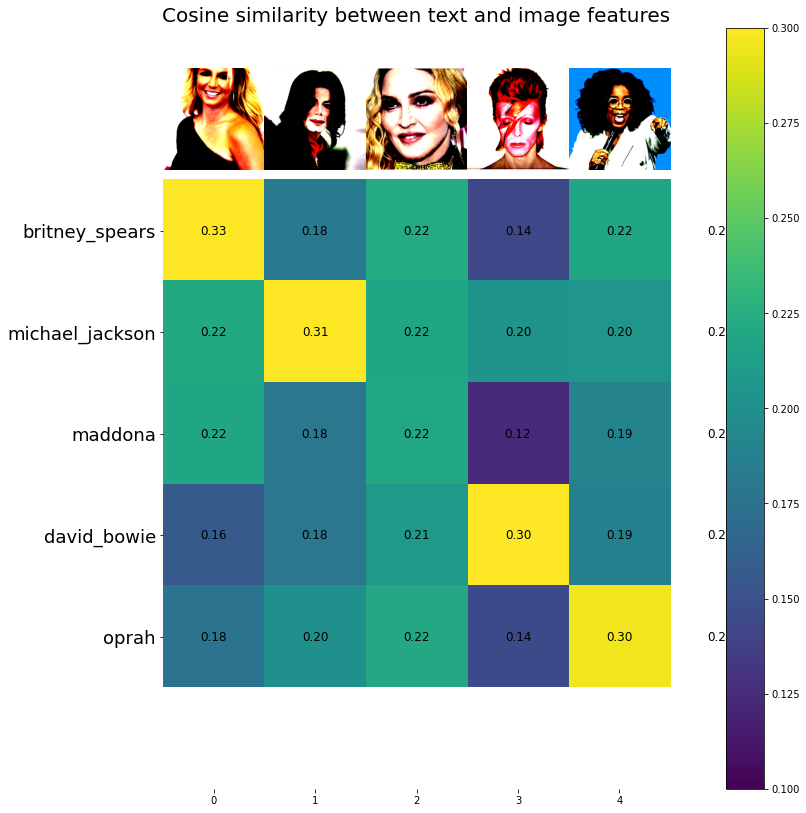

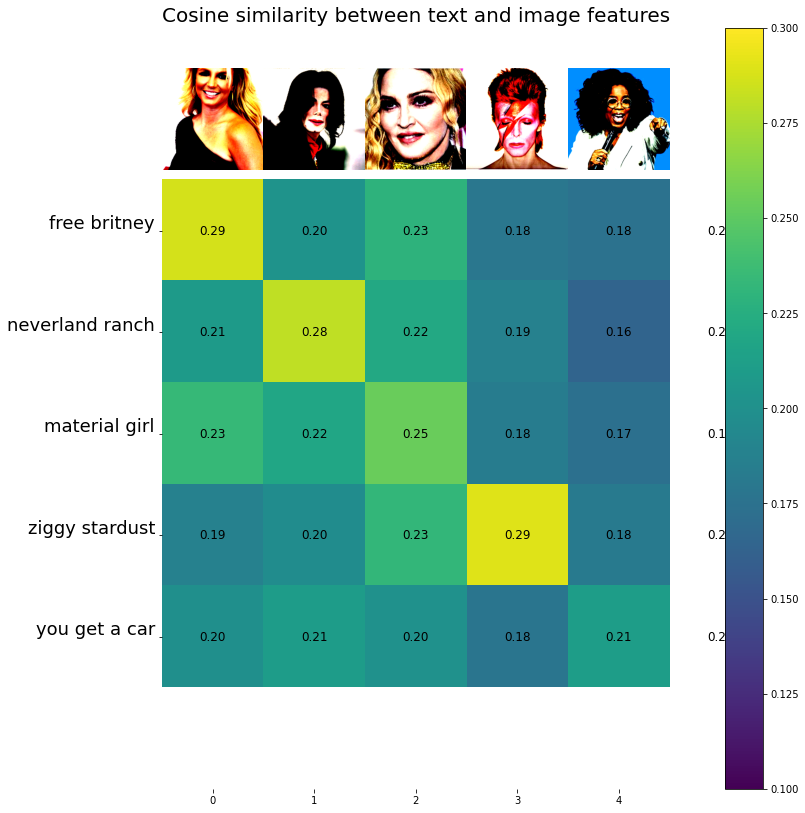

In [ ]:
run_tool()